In [1]:
import os
import uproot
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit

In [2]:
version = "v01.06"
path = f"/lfs/l1/legend/data/public/prodenv/prod-blind/ref/{version}/generated/tier/skm/phy/"
periods = os.listdir(path)

df_r0 =pd.read_hdf(f'{path}p03/r000/l200-p03-r000-phy-%-tier_skm-taup23.ph5')
df_r1 =pd.read_hdf(f'{path}p03/r001/l200-p03-r001-phy-%-tier_skm-taup23.ph5')
df_r2 =pd.read_hdf(f'{path}p03/r002/l200-p03-r002-phy-%-tier_skm-taup23.ph5')
df_r3 =pd.read_hdf(f'{path}p03/r003/l200-p03-r003-phy-%-tier_skm-taup23.ph5')
df_r4 =pd.read_hdf(f'{path}p03/r004/l200-p03-r004-phy-%-tier_skm-taup23.ph5')
df_r5 =pd.read_hdf(f'{path}p03/r005/l200-p03-r005-phy-%-tier_skm-taup23.ph5')
df_4r0 =pd.read_hdf(f'{path}p04/r000/l200-p04-r000-phy-%-tier_skm-taup23.ph5')
df_4r1 =pd.read_hdf(f'{path}p04/r001/l200-p04-r001-phy-%-tier_skm-taup23.ph5')
df_4r2 =pd.read_hdf(f'{path}p04/r002/l200-p04-r002-phy-%-tier_skm-taup23.ph5')
df_4r3 =pd.read_hdf(f'{path}p04/r003/l200-p04-r003-phy-%-tier_skm-taup23.ph5')

df = pd.concat([df_r0, df_r1, df_r2, df_r3, df_r4, df_r5, df_4r0, df_4r1, df_4r2, df_4r3], verify_integrity=True)

# load geds channelmap using legend_data_monitor
import legend_data_monitor as ldm
dataset = {
    "experiment": "L200",
    "period": "p03",
    "type": "phy",
    "version": "",
    "path" : "/lfs/l1/legend/data/public/prodenv/prod-blind/tmp/auto", # MPIK cluster
    "runs": 0,
}
geds = ldm.Subsystem("geds", dataset=dataset)
channel_map = geds.channel_map
# giving same name so that merging the two dataframes is easier
channel_map = channel_map.rename(columns = {"channel" : "channel_id"})
# merge dataframes and add metadata information (detector name, string, position, etc.)
df = df.merge(channel_map, on = "channel_id")

2023-08-22 16:07:14,728:  ---------------------------------------------
2023-08-22 16:07:14,730:  --- S E T T I N G  UP : geds
2023-08-22 16:07:14,731:  ---------------------------------------------
2023-08-22 16:07:14,800:  ... getting channel map
2023-08-22 16:07:16,267:  ... getting channel status


In [3]:
df_raw = df[(df.is_pulser == False) & (df.is_baseline == False) & (df.is_muon_tagged == False) & (df.is_physical == True) & (df.multiplicity == 1) & (df.is_valid_channel == True)]
df_LArC = df[(df.is_pulser == False) & (df.is_baseline == False) & (df.is_muon_tagged == False) & (df.is_physical == True) & (df.multiplicity == 1) & (df.is_valid_channel == True) & (df.is_lar_rejected == True)]
df_LArAC = df[(df.is_pulser == False) & (df.is_baseline == False) & (df.is_muon_tagged == False) & (df.is_physical == True) & (df.multiplicity == 1) & (df.is_valid_channel == True) & (df.is_lar_rejected == False)]

In [5]:
RAW_path_o25 = f"/lfs/l1/legend/users/calgaro/taup/legend-gamma-lines-analysis/output/2023-08-21/0_25keV/raw"
C_path_o25 = f"/lfs/l1/legend/users/calgaro/taup/legend-gamma-lines-analysis/output/2023-08-21/0_25keV/LArC"
AC_path_o25 = f"/lfs/l1/legend/users/calgaro/taup/legend-gamma-lines-analysis/output/2023-08-21/0_25keV/LArAC"

exposure_path = f"/lfs/l1/legend/users/calgaro/taup/legend-gamma-lines-analysis/livetime_and_exposure/exposure_in_kg_yr_on_p3_p4.json"

In [58]:
gammas = ['K42_1525',
 'K40_1461',
 'Co60_1332',
 'Co60_1173',
 'Ac228_911',
 'Bi212_727',
 'Tl208_2614',
 'Tl208_583',
 'Tl208_861',
 'Pa234m_1001',
 'Pb214_352',
 'Pb214_295',
 'Bi214_609',
 'Bi214_1378',
 'Bi214_1764',
 'Bi214_1238',
 'Bi214_2204',
 'Bi214_2448']
min_x = [1505, 1441, 1313, 1153, 891, 707, 2595, 563, 841, 981, 332, 275, 589, 1358, 1744, 1218, 2184, 2428]
max_x = [1545, 1481, 1353, 1193, 931, 747, 2635, 603, 881, 1021, 372, 315, 629, 1398, 1784, 1258, 2224, 2468]
bkg = ["step", "step", "linear", "linear", "linear", "linear", "flat", "linear", "linear", "linear", "quad", "quad", "linear", "linear", "linear", "linear", "flat", "flat"]
gammas_energies = [1524.7, 1460.8, 1332.5, 1173.2, 911.2, 727.3, 2614.5, 583.2, 860.6, 1001.0, 351.9, 295.2, 609.3, 1377.7, 1764.5, 1238.1, 2204.1, 2447.9]

gammas_2 = ["e+e-_Kr85_514", "Pb212_239_Pb214_242", "Ac228_338_Pb214_352", "Ac228_965_Ac228_969", "Bi214_1120_Zn65_1125"]
min_x_2 = [491, 218, 318, 945, 1100]
max_x_2 = [534, 262, 372, 989, 1145]
bkg_2 = ["linear", "quad", "quad", "linear", "linear"]
gammas_energies_2 = [[511.0, 514.0], [238.6, 242.0], [338.3, 351.9], [964.8, 969.0], [1120.3, 1125.0]]

18
18
18
18
18
5
5
5
5
5


In [7]:
# p3 + p4
ICPC_exposure = 8.0028 # kg yr
BEGe_exposure = 2.0987 # kg yr

dict_exposure = {"ICPC": ICPC_exposure, "BEGe": BEGe_exposure}

In [420]:
gamma     = []
cut       = []
det_type  = []
intensity = []
range_min = []
range_max = []
mean      = []
mean_sigma= []
fwhm      = []
fwhm_sigma= []
par0_0    = []
par0_1    = []
par1      = []
par2      = []
par0_0_sigma    = []
par0_1_sigma    = []
par1_sigma      = []
par2_sigma      = []
dict_exposure = {"ICPC": ICPC_exposure, "BEGe": BEGe_exposure}

for cut_path in [RAW_path_o25, AC_path_o25, C_path_o25]:
    for detector_type in ["BEGe", "ICPC"]:
            with open(os.path.join(cut_path, detector_type, "histo.gamma.log")) as f:
                f = f.readlines()
            start_and_stop = [index for index, element in enumerate(f) if ("*" in element)]

            for index in range(len(f)):
                if ("*" in f[index]):
                    if f[index].split(" ")[1] not in gammas_2:
                        gamma.append(f[index].split(" ")[1])
                        det_type.append(detector_type)
                        if "raw"  in cut_path: cut.append("raw")
                        if "LArAC" in cut_path: cut.append("LArAC")
                        if "LArC" in cut_path: cut.append("LArC")
                        diff = 17 # default value
                        if index in start_and_stop and index != 1:
                            pos = start_and_stop.index(index)
                            pos_minus_1 = pos-1
                            diff = index - start_and_stop[pos_minus_1]

                        for sub_index in range(diff):
                            if "intensity" in f[index + sub_index]:
                                try:
                                    intensity.append(float(f[index + sub_index].split(" ")[9][1:])/ dict_exposure[detector_type])
                                    range_min.append(float(f[index + sub_index].split(" ")[10].split(",")[0][1:])/ dict_exposure[detector_type]) 
                                    range_max.append(float(f[index + sub_index].split(" ")[10].split(",")[1][:-2])/ dict_exposure[detector_type])
                                except: 
                                    intensity.append(float(f[index+ sub_index].split(" ")[10][1:])/ dict_exposure[detector_type]) 
                                    range_min.append(0.0)
                                    range_max.append(0.0)
                            if "mean0" in f[index + sub_index]:
                                mean.append(float(f[index + sub_index].split("(")[1].split("+-")[0]))
                                mean_sigma.append(float(f[index + sub_index].split("(")[1].split("+-")[1].split(")")[0])) 
                            if "fwhm0" in f[index + sub_index]:
                                fwhm.append(float(f[index + sub_index].split("(")[1].split("+-")[0]))
                                fwhm_sigma.append(float(f[index + sub_index].split("(")[1].split("+-")[1].split(")")[0]))
                            if "par0.0:" in f[index + sub_index] and float(f[index + sub_index].split("(")[1].split("+-")[0]) not in par0_0:
                                par0_0.append(float(f[index + sub_index].split("(")[1].split("+-")[0]))
                                par0_0_sigma.append(float(f[index + sub_index].split("(")[1].split("+-")[1].split(")")[0]))
                            if "par0.1:" in f[index + sub_index]:
                                par0_1.append(float(f[index + sub_index].split("(")[1].split("+-")[0]))
                                par0_1_sigma.append(float(f[index + sub_index].split("(")[1].split("+-")[1].split(")")[0]))
                            if "par1:" in f[index + sub_index]:
                                par1.append(float(f[index + sub_index].split("(")[1].split("+-")[0]))
                                par1_sigma.append(float(f[index + sub_index].split("(")[1].split("+-")[1].split(")")[0]))
                            if "par2:" in f[index + sub_index]:
                                par2.append(float(f[index + sub_index].split("(")[1].split("+-")[0]))
                                par2_sigma.append(float(f[index + sub_index].split("(")[1].split("+-")[1].split(")")[0]))
                if index in start_and_stop:
                    # check length of bkg params
                    if len(par0_0) < len(mean):
                        par0_0.append(0)
                        par0_0_sigma.append(0)
                    if len(par0_1) < len(mean):
                        par0_1.append(0)
                        par0_1_sigma.append(0)
                    if len(par1) < len(mean):
                        par1.append(0)
                        par1_sigma.append(0)
                    if len(par2) < len(mean):
                        par2.append(0)
                        par2_sigma.append(0)
                                
df = pd.DataFrame()

print(len(gamma))
print(len(det_type))
print(len(cut))
print(len(intensity))
print(len(range_min))
print(len(range_max))
print(len(mean), len(mean_sigma))
print(len(fwhm), len(fwhm_sigma))
print(len(par0_0), len(par0_0_sigma))
print(len(par0_1), len(par0_1_sigma))
print(len(par1), len(par1_sigma))
print(len(par2), len(par2_sigma))

df["gamma"]     = gamma
df["det_type"]  = det_type
df["cut"]       = cut
df["intensity"] = intensity
df["range_min"] = range_min
df["range_max"] = range_max
"""
df["mean"]      = mean
df["mean_sigma"]= mean_sigma
df["fwhm"]      = fwhm
df["fwhm_sigma"]= fwhm_sigma
df["par0_0"]      = par0_0
df["par0_0_sigma"]= par0_0_sigma
df["par0_1"]      = par0_1
df["par0_1_sigma"]= par0_1_sigma
df["par1"]        = par1
df["par1_sigma"]  = par1_sigma
df["par2"]        = par2
df["par2_sigma"]  = par2_sigma
"""
df

df_2 = df.copy()
df_2["yerr_low"] = df_2.apply(lambda row: max(row["intensity"] - row["range_min"], 0), axis=1)
df_2["yerr_upp"] = df_2.apply(lambda row: max(-row["intensity"] + row["range_max"], 0), axis=1)
df_2.loc[df_2["intensity"] == df_2["yerr_low"], "yerr_low"] = 0
det_type_order = ["BEGe", "ICPC"]
df_2['det_type'] = pd.Categorical(df_2['det_type'], categories=det_type_order, ordered=True)
df_2 = df_2.sort_values("det_type")
df = df_2.copy()
df

108
108
108
108
108
108
108 108
108 108
108 108
108 108
108 108
108 108


,gamma,det_type,cut,intensity,range_min,range_max,yerr_low,yerr_upp
0,K42_1525,BEGe,raw,152.245676,143.442607,161.250298,8.803069,9.004622
51,Bi214_1238,BEGe,LArAC,0.915329,0.000000,0.000000,0.000000,0.000000
50,Bi214_1764,BEGe,LArAC,3.335398,2.049840,4.651927,1.285558,1.316529
49,Bi214_1378,BEGe,LArAC,2.543956,0.000000,0.000000,0.000000,0.000000
48,Bi214_609,BEGe,LArAC,1.346071,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
58,Ac228_911,ICPC,LArAC,6.411506,4.824686,7.750162,1.586820,1.338656
57,Co60_1173,ICPC,LArAC,1.564952,0.000000,0.000000,0.000000,0.000000
56,Co60_1332,ICPC,LArAC,1.443245,0.000000,0.000000,0.000000,0.000000
62,Tl208_861,ICPC,LArAC,1.781626,0.000000,0.000000,0.000000,0.000000


In [424]:
my_g = "Co60_1332"
my_cut = "LArC"
df[(df.gamma==my_g) & (df.cut==my_cut)]

,gamma,det_type,cut,intensity,range_min,range_max,yerr_low,yerr_upp
74,Co60_1332,BEGe,LArC,2.278077,0.756659,3.867632,1.521418,1.589555
92,Co60_1332,ICPC,LArC,0.929425,0.445900,1.796859,0.483525,0.867434


In [376]:
df_avg = df[(df.gamma==my_g) & (df.cut==my_cut)].copy()
bege = df_avg[(df_avg.det_type=="BEGe")]["intensity"].iloc[0]
icpc = df_avg[(df_avg.det_type=="ICPC")]["intensity"].iloc[0]
bege_low = df_avg[(df_avg.det_type=="BEGe")]["yerr_low"].iloc[0]
icpc_low = df_avg[(df_avg.det_type=="ICPC")]["yerr_low"].iloc[0]
bege_upp = df_avg[(df_avg.det_type=="BEGe")]["yerr_upp"].iloc[0]
icpc_upp = df_avg[(df_avg.det_type=="ICPC")]["yerr_upp"].iloc[0]
print( (bege*dict_exposure["BEGe"] + icpc*dict_exposure["ICPC"])/(dict_exposure["BEGe"]+dict_exposure["ICPC"]))
print( (bege_low*dict_exposure["BEGe"] + icpc_low*dict_exposure["ICPC"])/(dict_exposure["BEGe"]+dict_exposure["ICPC"]))
print( (bege_upp*dict_exposure["BEGe"] + icpc_upp*dict_exposure["ICPC"])/(dict_exposure["BEGe"]+dict_exposure["ICPC"]))

1.4770083650942925
1.1537890412315
1.1085482354105824


891
LArAC 3.231 3.054 2.9640000000000004 911.23035 0.6350785562632697 1.49561
par0_0 3.98227 par1 0.0156
par0_0_sigma 0.6624 par1_sigma 0.02935
891


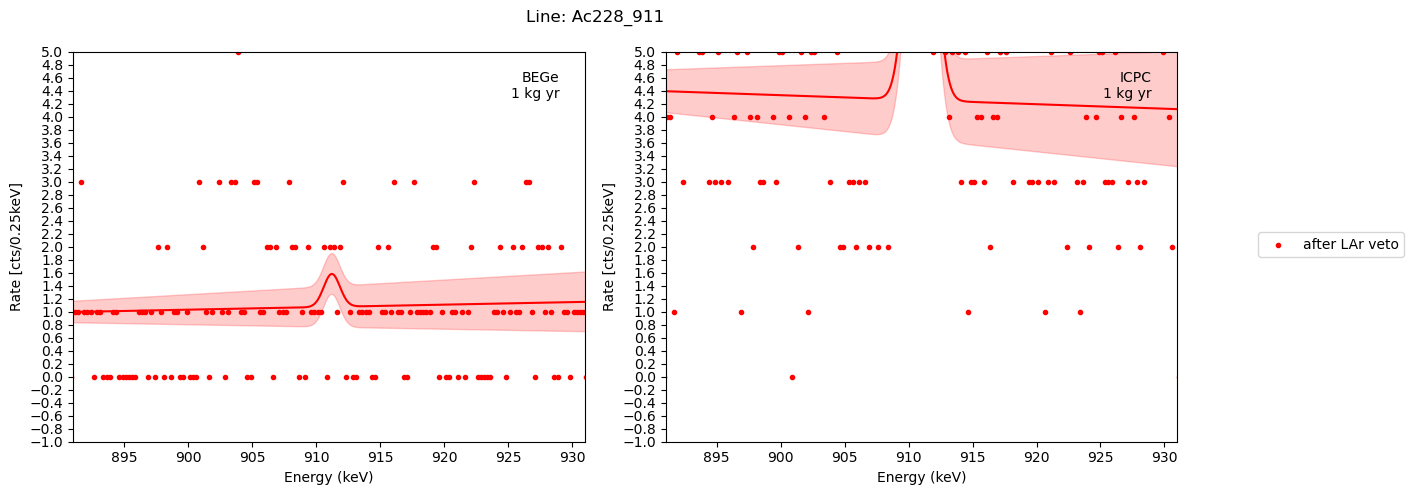

332
LArAC 25.935 6.855 6.7130000000000045 351.47465 0.4251592356687898 1.00125
par0_0 2.10355 par1 0.0194275 par2 -0.0008275
par0_0_sigma 0.3184075 par1_sigma 0.036435 par2_sigma 0.0008825
332


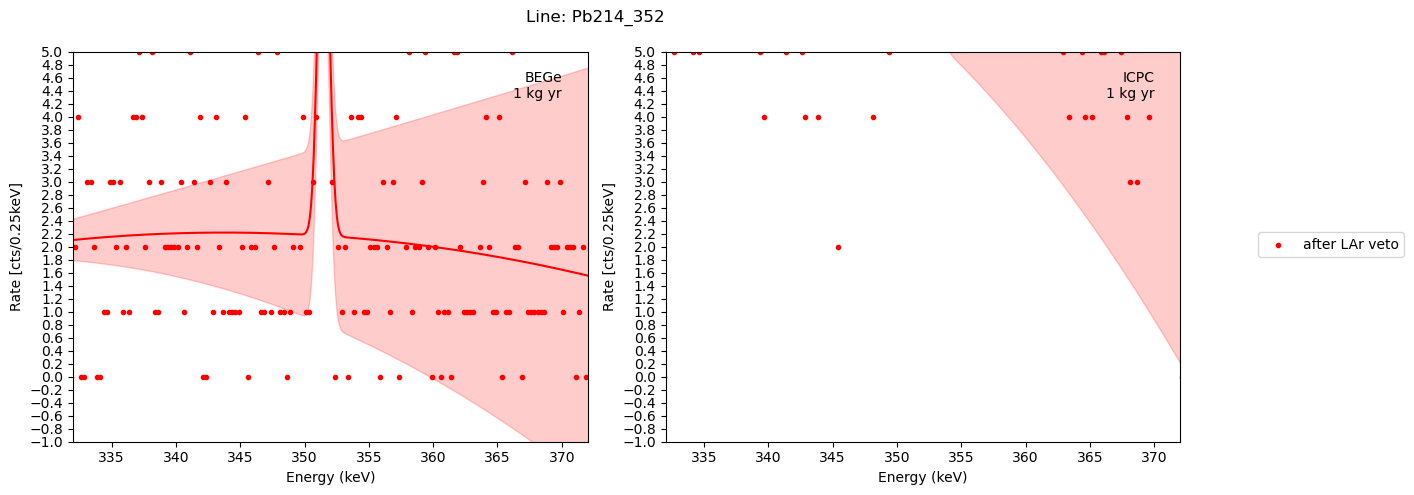

In [327]:
bin_width = 0.25  # leave this for visualization reasons (but remember the final fit considers a bin widht of 0.25 keV)
min_energy = 0
max_energy = 5000
num_bins = int((max_energy - min_energy) / bin_width)

x_fit = np.linspace(0, 5000, 50000)

def step_function(x, centroid, low_value, upp_value):
    return np.where(x >= centroid, upp_value, low_value)

def gaussian(x, intensity, mu, sigma):
    # from BAT:
    #    par[2]/sqrt(2*TMath::Pi()*pow(par[1]/2.35,2))*exp(-0.5*pow(x[0]-par[0],2)/pow(par[1]/2.35,2));
    return (intensity / (np.sqrt(2*np.pi)*sigma)) * np.exp(-0.5 * (((x - mu) / sigma)**2))
    #return (intensity / ((2*np.pi)*sigma*sigma)) * np.exp(-0.5 * (((x - mu) / sigma)**2))
    
def fit_flat(a):
    return a
def fit_linear(x, off, a, b):
    return a + b*(x-off)
def fit_quad(x, off, a, b,c):
    return a + b*(x-off) + c*(x-off)**2


color_cut = {"raw" : "#07A9FF", "LArAC": "red", "LArC" : "orange"}
legend_dict = {"raw" : "prior LAr veto", "LArAC": "after LAr veto", "LArC" : "coincident with LAr veto"}
#dict_exposure = {"ICPC": ICPC_exposure, "BEGe": BEGe_exposure}
dict_exposure = {"ICPC": 1, "BEGe": 1}

for idx_g,g in enumerate(gammas):
    if "911" not in g and "352" not in g:
        continue
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))  
    
    for idx,det in enumerate(["BEGe", "ICPC"]):
        df_data = df.copy()
        df_raw_det = df_raw.copy()
        df_LArC_det = df_LArC.copy()
        df_LArAC_det = df_LArAC.copy()
        
        # select data coming from one detector type only
        if det == "BEGe":
            df_raw_det = df_raw_det[df_raw_det['name'].str.startswith('B')]
            df_LArC_det = df_LArC_det[df_LArC_det['name'].str.startswith('B')]
            df_LArAC_det = df_LArAC_det[df_LArAC_det['name'].str.startswith('B')]
        if det == "ICPC":
            df_raw_det = df_raw_det[df_raw_det['name'].str.startswith('V')]
            df_LArC_det = df_LArC_det[df_LArC_det['name'].str.startswith('V')]
            df_LArAC_det = df_LArAC_det[df_LArAC_det['name'].str.startswith('V')]

        # get energies of interest
        df_raw_det = df_raw_det[(df_raw_det["energy"] >= min_x[idx_g]) & (df_raw_det["energy"] <= max_x[idx_g])]
        df_LArC_det = df_LArC_det[(df_LArC_det["energy"] >= min_x[idx_g]) & (df_LArC_det["energy"] <= max_x[idx_g])]
        df_LArAC_det = df_LArAC_det[(df_LArAC_det["energy"] >= min_x[idx_g]) & (df_LArAC_det["energy"] <= max_x[idx_g])]
        
          
        # ------------------------------------------------------------------------------------------------------------
        # start plot
        ax = axes[idx]  

        # RAW DATA
        hist_values_raw, bin_edges_raw = np.histogram(df_raw_det['energy'], bins=num_bins, range=(min_energy, max_energy))
        bin_midpoints_raw = (bin_edges_raw[:-1] + bin_edges_raw[1:]) / 2
        #if det == "BEGe":
        #    ax.scatter(bin_midpoints_raw, hist_values_raw / dict_exposure[det], marker='.', color=color_cut["raw"], label=legend_dict["raw"])
        #else:
        #    ax.scatter(bin_midpoints_raw, hist_values_raw / dict_exposure[det], marker='.', color=color_cut["raw"])
        
        # LArAC DATA
        hist_values_LArAC, bin_edges_LArAC = np.histogram(df_LArAC_det['energy'], bins=num_bins, range=(min_energy, max_energy))
        bin_midpoints_LArAC = (bin_edges_LArAC[:-1] + bin_edges_LArAC[1:]) / 2
        if det == "BEGe":
            ax.scatter(bin_midpoints_LArAC, hist_values_LArAC / dict_exposure[det], marker='.', color=color_cut["LArAC"], label=legend_dict["LArAC"])
        else:
            ax.scatter(bin_midpoints_LArAC, hist_values_LArAC / dict_exposure[det], marker='.', color=color_cut["LArAC"])
        
        
        # LArC DATA
        hist_values_LArC, bin_edges_LArC = np.histogram(df_LArC_det['energy'], bins=num_bins, range=(min_energy, max_energy))
        bin_midpoints_LArC = (bin_edges_LArC[:-1] + bin_edges_LArC[1:]) / 2
        #if det == "BEGe":
        #    ax.scatter(bin_midpoints_LArC, hist_values_LArC / dict_exposure[det], marker='.', color=color_cut["LArC"], label=legend_dict["LArC"])
        #else:
        #    ax.scatter(bin_midpoints_LArC, hist_values_LArC / dict_exposure[det], marker='.', color=color_cut["LArC"])
        
        # Generate the best-fit curve
        for my_cut in ["LArAC"]:#"raw", "LArAC", "LArC"]:
            centroid = gammas_energies[idx_g]
            offset = min_x[idx_g] # there is an offest set to range.first in BAT code
            print(offset)
            condition = (df_data.gamma == g) & (df_data.cut == my_cut) & (df_data.det_type == det)
            df_data = df_data.copy()[condition]
            intensity = df_data["intensity"].iloc[0] 
            intensity_sigma_upp = df_data["yerr_upp"].iloc[0]
            intensity_sigma_low = df_data["yerr_low"].iloc[0] 
            mean      = df_data["mean"].iloc[0]
            stddev    = df_data["fwhm"].iloc[0] / 2.355
            fwhm      = df_data["fwhm"].iloc[0] 
            mean_sigma = df_data["mean_sigma"].iloc[0]
            stddev_sigma = df_data["fwhm_sigma"].iloc[0] / 2.355
            fwhm_sigma   = df_data["fwhm_sigma"].iloc[0] 
            # gaussian signal
            if det=="BEGe":
                print(my_cut, intensity, intensity_sigma_low, intensity_sigma_upp, mean, stddev, fwhm)
            
            y_fit = gaussian(x_fit, intensity, mean, stddev)  * bin_width
            y_fit_lower = gaussian(x_fit, intensity, mean, stddev)  * bin_width
            y_fit_upper = gaussian(x_fit, intensity, mean, stddev)  * bin_width
            #y_fit_lower = gaussian(x_fit, intensity-intensity_sigma_low, mean-mean_sigma, stddev-stddev_sigma) * bin_width
            #y_fit_upper = gaussian(x_fit, intensity+intensity_sigma_upp, mean+mean_sigma, stddev+stddev_sigma) * bin_width
            
            # add background
            if bkg[idx_g] == "step":
                if df_data["par0_0"].iloc[0]!=0 and df_data["par0_1"].iloc[0]!=0:
                    if det=="BEGe":
                        print("par0_0", df_data["par0_0"].iloc[0], "par0_1", df_data["par0_1"].iloc[0])
                        print("par0_0_sigma", df_data["par0_0_sigma"].iloc[0], "par0_1_sigma", df_data["par0_1_sigma"].iloc[0])
                    
                    a = df_data["par0_0"].iloc[0] * bin_width
                    a_std = df_data["par0_0_sigma"].iloc[0] * bin_width
                    b = df_data["par0_1"].iloc[0] * bin_width
                    b_std = df_data["par0_1_sigma"].iloc[0] * bin_width
                    y_fit += step_function((x_fit-offset), centroid, a, b)
                    y_fit_lower += step_function((x_fit-offset), centroid, a-a_std, b-b_std)
                    y_fit_upper += step_function((x_fit-offset), centroid, a+a_std, b+b_std)
            if bkg[idx_g] == "flat":
                if df_data["par0_0"].iloc[0]!=0:
                    if det=="BEGe":
                        print("par0_0", df_data["par0_0"].iloc[0])
                        print("par0_0_sigma", df_data["par0_0_sigma"].iloc[0])
                    
                    a = df_data["par0_0"].iloc[0] * bin_width
                    a_std = df_data["par0_0_sigma"].iloc[0] * bin_width
                    y_fit += fit_flat(a)
                    y_fit_lower += fit_flat(a-a_std)
                    y_fit_upper += fit_flat(a+a_std)
            if bkg[idx_g] == "linear":
                if df_data["par0_0"].iloc[0]!=0 and df_data["par1"].iloc[0]!=0:
                    if det=="BEGe":
                        print("par0_0", df_data["par0_0"].iloc[0], "par1", df_data["par1"].iloc[0])
                        print("par0_0_sigma", df_data["par0_0_sigma"].iloc[0], "par1_sigma", df_data["par1_sigma"].iloc[0])
                    
                    a = df_data["par0_0"].iloc[0] * bin_width
                    a_std = df_data["par0_0_sigma"].iloc[0] * bin_width
                    b = df_data["par1"].iloc[0] * bin_width
                    b_std = df_data["par1_sigma"].iloc[0] * bin_width
                    y_fit += fit_linear(x_fit, offset, a, b)
                    y_fit_lower += fit_linear(x_fit, offset, a-a_std, b-b_std)
                    y_fit_upper += fit_linear(x_fit, offset, a+a_std, b+b_std)
            if bkg[idx_g] == "quad":
                if df_data["par0_0"].iloc[0]!=0 and df_data["par1"].iloc[0]!=0 and df_data["par2"].iloc[0]!=0:
                    a = df_data["par0_0"].iloc[0] * bin_width
                    a_std = df_data["par0_0_sigma"].iloc[0] * bin_width
                    b = df_data["par1"].iloc[0] * bin_width
                    b_std = df_data["par1_sigma"].iloc[0] * bin_width
                    c = df_data["par2"].iloc[0] * bin_width
                    c_std = df_data["par2_sigma"].iloc[0] * bin_width
                    if det=="BEGe":
                        print("par0_0", a, "par1", b, "par2", c)
                        print("par0_0_sigma", a_std, "par1_sigma", b_std, "par2_sigma", c_std)
                    y_fit += fit_quad(x_fit, offset, a, b, c)
                    y_fit_lower += fit_quad(x_fit, offset, a-a_std, b-b_std, c-c_std)
                    y_fit_upper += fit_quad(x_fit, offset, a+a_std, b+b_std, c+c_std)
            
            # plot
            ax.plot(x_fit, y_fit / dict_exposure[det], color=color_cut[my_cut])
            ax.fill_between(x_fit, y_fit_lower / dict_exposure[det], y_fit_upper / dict_exposure[det], color=color_cut[my_cut], alpha=0.2)

            # some plotting styles
            energy_values_raw = hist_values_raw / dict_exposure[det]
            energy_values_LArC = hist_values_LArC / dict_exposure[det]
            energy_values_LArAC = hist_values_LArAC / dict_exposure[det]
            ymax_energy = max(energy_values_raw.max(), energy_values_LArC.max(), energy_values_LArAC.max(), 5)
            ax.set_ylim(-1, 5)#ymax_energy)
            ax.set_xlim(min_x[idx_g], max_x[idx_g])
            import matplotlib.ticker as ticker
            ax.yaxis.set_major_locator(ticker.MaxNLocator(30))
            ax.set_xlabel('Energy (keV)')
            if dict_exposure[det]==1:
                ax.set_ylabel(f'Rate [cts/{bin_width}keV]')
            else:
                ax.set_ylabel(f'Rate [cts/(kg yr {bin_width}keV)]')
            ax.text(0.95, 0.95, det+f"\n{round(dict_exposure[det],3)} kg yr", transform=ax.transAxes, va="top", ha="right")
        
    fig.suptitle(f"Line: {g}")
    fig.legend(loc='upper right', bbox_to_anchor=(1.18, 0.55))
    plt.tight_layout() 
    plt.show()

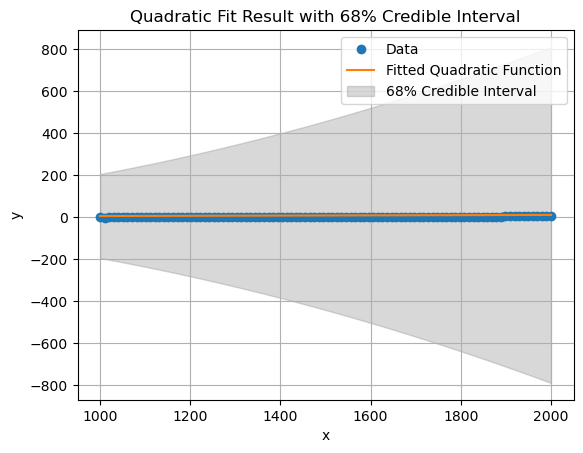

In [279]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated example data
x_data = np.linspace(1000, 2000, 100)
y_data = 0.00529 * (x_data - 1313) + 1.26908 + np.random.normal(0, 0.1, len(x_data))  # Simulated noisy data

# Define the quadratic function
def quadratic_function(x, a, b, c):
    return a + b * x + c * x**2

# Example best-fit parameters
best_fit_params = [1.26908, 0.00529, 0.0]  # Example best-fit parameters [a, b, c]

# Example parameter uncertainties (standard deviations)
param_uncertainties = [0.02, 0.0001, 0.0002]  # Example uncertainties [std_a, std_b, std_c]

# Generate x values for plotting
x_fit_values = np.linspace(1000, 2000, 100)

# Calculate the fitted function values using best-fit parameters
fitted_values = quadratic_function(x_fit_values, *best_fit_params)

# Calculate upper and lower bounds of the 68% credible interval
upper_bound = quadratic_function(x_fit_values, *np.array(best_fit_params) + param_uncertainties)
lower_bound = quadratic_function(x_fit_values, *np.array(best_fit_params) - param_uncertainties)

# Plot the data, fitted function, and 68% credible interval
plt.plot(x_data, y_data, 'o', label='Data')
plt.plot(x_fit_values, fitted_values, label='Fitted Quadratic Function')
plt.fill_between(x_fit_values, lower_bound, upper_bound, color='gray', alpha=0.3, label='68% Credible Interval')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Quadratic Fit Result with 68% Credible Interval')
plt.legend()
plt.grid(True)
plt.show()


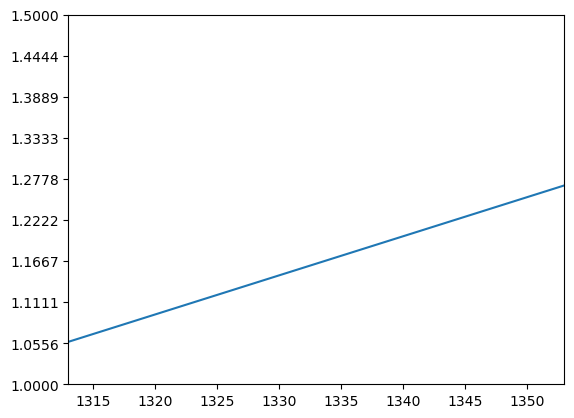

In [261]:
#plt.plot(x_fit, step_function(x_fit, 1524.7, 0.423, 0.382)+gaussian(x_fit, 53.9/(np.sqrt(2)*0.83), 1525, 0.83), color='g')
x = np.linspace(1313,1353,40)
plt.plot(x, 0.00529*(x-1353) + 1.26908) # 0.25 , Co60 @ 1332
plt.xlim(1313, 1353)
num_ticks = 10  # Number of ticks you want
plt.yticks(np.linspace((1.0), (1.5), num_ticks))
plt.show()

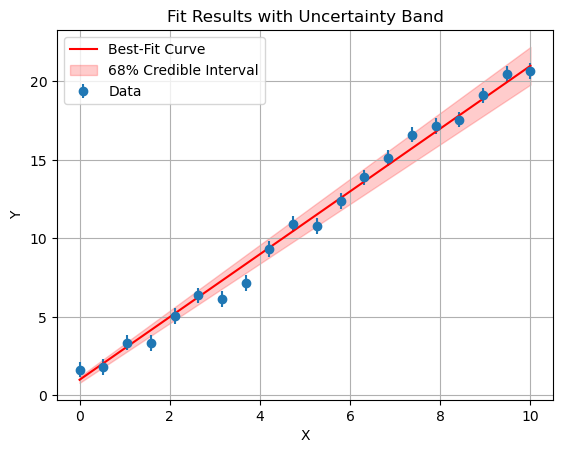

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated data points
x_data = np.linspace(0, 10, 20)
y_data = 2 * x_data + 1 + np.random.normal(0, 0.5, len(x_data))

# Fit results (these should be extracted from your BAT fit)
best_fit_slope = 2.0
best_fit_intercept = 1.0
slope_uncertainty = 0.1
intercept_uncertainty = 0.2

# Generate the best-fit curve
x_fit = np.linspace(0, 10, 100)
y_fit = best_fit_slope * x_fit + best_fit_intercept

# Generate the uncertainty band
y_fit_upper = (best_fit_slope + slope_uncertainty) * x_fit + (best_fit_intercept + intercept_uncertainty)
y_fit_lower = (best_fit_slope - slope_uncertainty) * x_fit + (best_fit_intercept - intercept_uncertainty)

# Plot the data, best-fit result, and uncertainty band
plt.figure()
plt.errorbar(x_data, y_data, yerr=0.5, fmt="o", label="Data")
plt.plot(x_fit, y_fit, label="Best-Fit Curve", color="red")
plt.fill_between(x_fit, y_fit_lower, y_fit_upper, color="red", alpha=0.2, label="68% Credible Interval")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Fit Results with Uncertainty Band")
plt.grid()
plt.show()

